In [1]:
import pandas as pd
import numpy as np

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Convert date columns
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

In [4]:
# Step 1: Combine Customers and Transactions data for segmentation

# Aggregate transaction data to calculate total spend and transaction count per customer
transaction_features = transactions.groupby("CustomerID").agg(
    TotalSpend=("TotalValue", "sum"),
    TransactionCount=("TransactionID", "nunique")
).reset_index()

# Merge customer profile information with transaction features
customer_segmentation_data = pd.merge(customers, transaction_features, on="CustomerID", how="inner")

# Display the combined dataset
customer_segmentation_data.head()


,CustomerID,CustomerName,Region,SignupDate,TotalSpend,TransactionCount
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3


In [5]:
customer_segmentation_data.shape

(199, 6)

In [7]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Select features for clustering
features = customer_segmentation_data[["TotalSpend", "TransactionCount", "Region"]]

# Normalize numerical features (TotalSpend and TransactionCount)
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(features[["TotalSpend", "TransactionCount"]])

# One-hot encode categorical feature (Region)
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
categorical_features = encoder.fit_transform(features[["Region"]])

# Combine normalized numerical and encoded categorical features
clustering_features = np.hstack([numerical_features, categorical_features])

# Display the shape of the final feature matrix
clustering_features.shape


(199, 6)

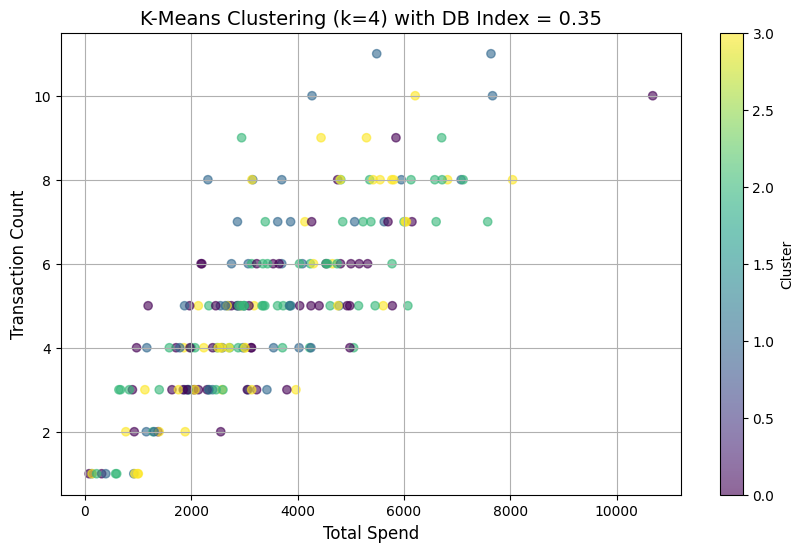

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Step 1: Apply K-Means Clustering
k = 4 # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(clustering_features)

# Add cluster labels to the customer dataset for visualization
customer_segmentation_data["Cluster"] = clusters

# Step 2: Compute Davies-Bouldin Index
db_index = davies_bouldin_score(clustering_features, clusters)

# Step 3: Visualize the Clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    customer_segmentation_data["TotalSpend"],
    customer_segmentation_data["TransactionCount"],
    c=customer_segmentation_data["Cluster"],
    cmap="viridis",
    alpha=0.6
)
plt.colorbar(scatter, label="Cluster")
plt.title(f"K-Means Clustering (k={k}) with DB Index = {db_index:.2f}", fontsize=14)
plt.xlabel("Total Spend", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.grid(True)
plt.show()
